# Players Movements Between Clubs

## Abstract
This analysis explores football player movements between clubs using geospatial data visualization techniques.<br>
The study exploits pandas for data management, geopandas for spatial operations, and matplotlib for visualizations.<br>
The dataset includes player, club, and appearance records, sourced from CSV files.<br>
Initial steps involve geocoding club locations using the OpenCage API when coordinates are unavailable.

Visualizations are divided into three main perspectives: a global view showcasing club locations across the world,<br>
a detailed Europe view highlighting player movements within European countries, and a zoomed-in view focusing on<br>
specific regions within Europe.<br>
These visualizations utilize GeoDataFrames to plot club locations and player movements as points and lines on<br>
geographic maps.

Additionally, the analysis includes a detailed examination of the player with the highest number of club movements.<br>
By merging player and club data, the study identifies and visualizes the movements of this player between<br>
previous and current clubs.<br>
This visualization employs markers to denote the player's movements as well as lines connecting the<br>
geographical locations of these clubs.

<br>
<b>Objective:</b> Visualize the movement of players between clubs
<br><br>

In [428]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import string
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.geocoders import OpenCage
from shapely.geometry import Point
from opencage.geocoder import OpenCageGeocode
import time
plt.style.use('ggplot')

In [429]:
df_players = pd.read_csv('AssignmentData/players.csv')
df_club = pd.read_csv('AssignmentData/clubs.csv')
df_app = pd.read_csv('AssignmentData/appearances.csv')

pd.set_option('display.max_columns', None) # Display all columns

### Data Cleaning

In [430]:
df_players.columns

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'market_value_in_eur',
       'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name'],
      dtype='object')

In [431]:
df_players = df_players[
['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'market_value_in_eur',
       'highest_market_value_in_eur', 'contract_expiration_date',
       'current_club_domestic_competition_id',
       'current_club_name']
]

In [432]:
df_club.columns

Index(['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'stadium_seats', 'net_transfer_record', 'coach_name', 'last_season',
       'url'],
      dtype='object')

In [433]:
df_club = df_club[
['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'net_transfer_record', 'last_season']
]

In [434]:
df_app

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507346,4172154_659813,4172154,659813,15,15,2023-11-30,Piero Hincapié,EL,0,0,0,0,90
1507347,4172154_696027,4172154,696027,15,15,2023-11-30,Ayman Aourir,EL,0,0,0,0,2
1507348,4172154_7161,4172154,7161,15,15,2023-11-30,Jonas Hofmann,EL,0,0,0,0,10
1507349,4172154_743395,4172154,743395,15,15,2023-11-30,Noah Mbamba,EL,0,0,0,0,45


### Geocode Club Locations
Geolocation of club locations is performed using the OpenCage Geocoder API (OpenCage).<br>
If latitude and longitude are not available in the df_club DataFrame,<br>
they are fetched using the geocode_stadium function and added to the DataFrame.

In [435]:
# Initialize geolocator with your OpenCage API key
geolocator = OpenCage(api_key='4bc0ca7f00f542c785d122597bbd0edf')

# Function to get latitude and longitude
def geocode_stadium(stadium_name):
    try:
        location = geolocator.geocode(stadium_name)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# Apply geocoding to the stadium names if coordinates are not available
if 'latitude' not in df_club.columns or 'longitude' not in df_club.columns:
    df_club['latitude'], df_club['longitude'] = zip(*df_club['stadium_name'].apply(lambda x: geocode_stadium(x) if pd.notnull(x) else (None, None)))
    # Add a delay between requests to avoid hitting rate limits
    # time.sleep(1)

# Drop rows with missing coordinates
df_club.dropna(subset=['latitude', 'longitude'], inplace=True)

### Create GeoDataFrames

In [436]:
# Create GeoDataFrame for clubs
gdf_club = gpd.GeoDataFrame(df_club, geometry=gpd.points_from_xy(df_club.longitude, df_club.latitude))

# Merge player data with club data for current and previous clubs
df_player_movements = df_app[['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates()

# Merge to get current and previous club locations
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_club_id', right_on='club_id', suffixes=('_prev', '_curr'))
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_current_club_id', right_on='club_id', suffixes=('_prev', '_curr'))

# Filter out movements with missing coordinates
df_player_movements.dropna(subset=['latitude_prev', 'longitude_prev', 'latitude_curr', 'longitude_curr'], inplace=True)

### Generate and Visualize graph with all Club (Global View) 
<i>reverse_geocode</i> function converts latitude and longitude coordinates back to location names (e.g., country names) using OpenCage API.

In [437]:
# Function to reverse geocode coordinates to location names
geocoder = OpenCageGeocode('4bc0ca7f00f542c785d122597bbd0edf')

def reverse_geocode(lat, lng):
    result = geocoder.reverse_geocode(lat, lng)
    if result and len(result):
        return result[0]['components']['country']
    return None

# Convert latitude and longitude to location names using OpenCage
gdf_club['club_location'] = gdf_club.apply(lambda row: reverse_geocode(row['latitude'], row['longitude']), axis=1)

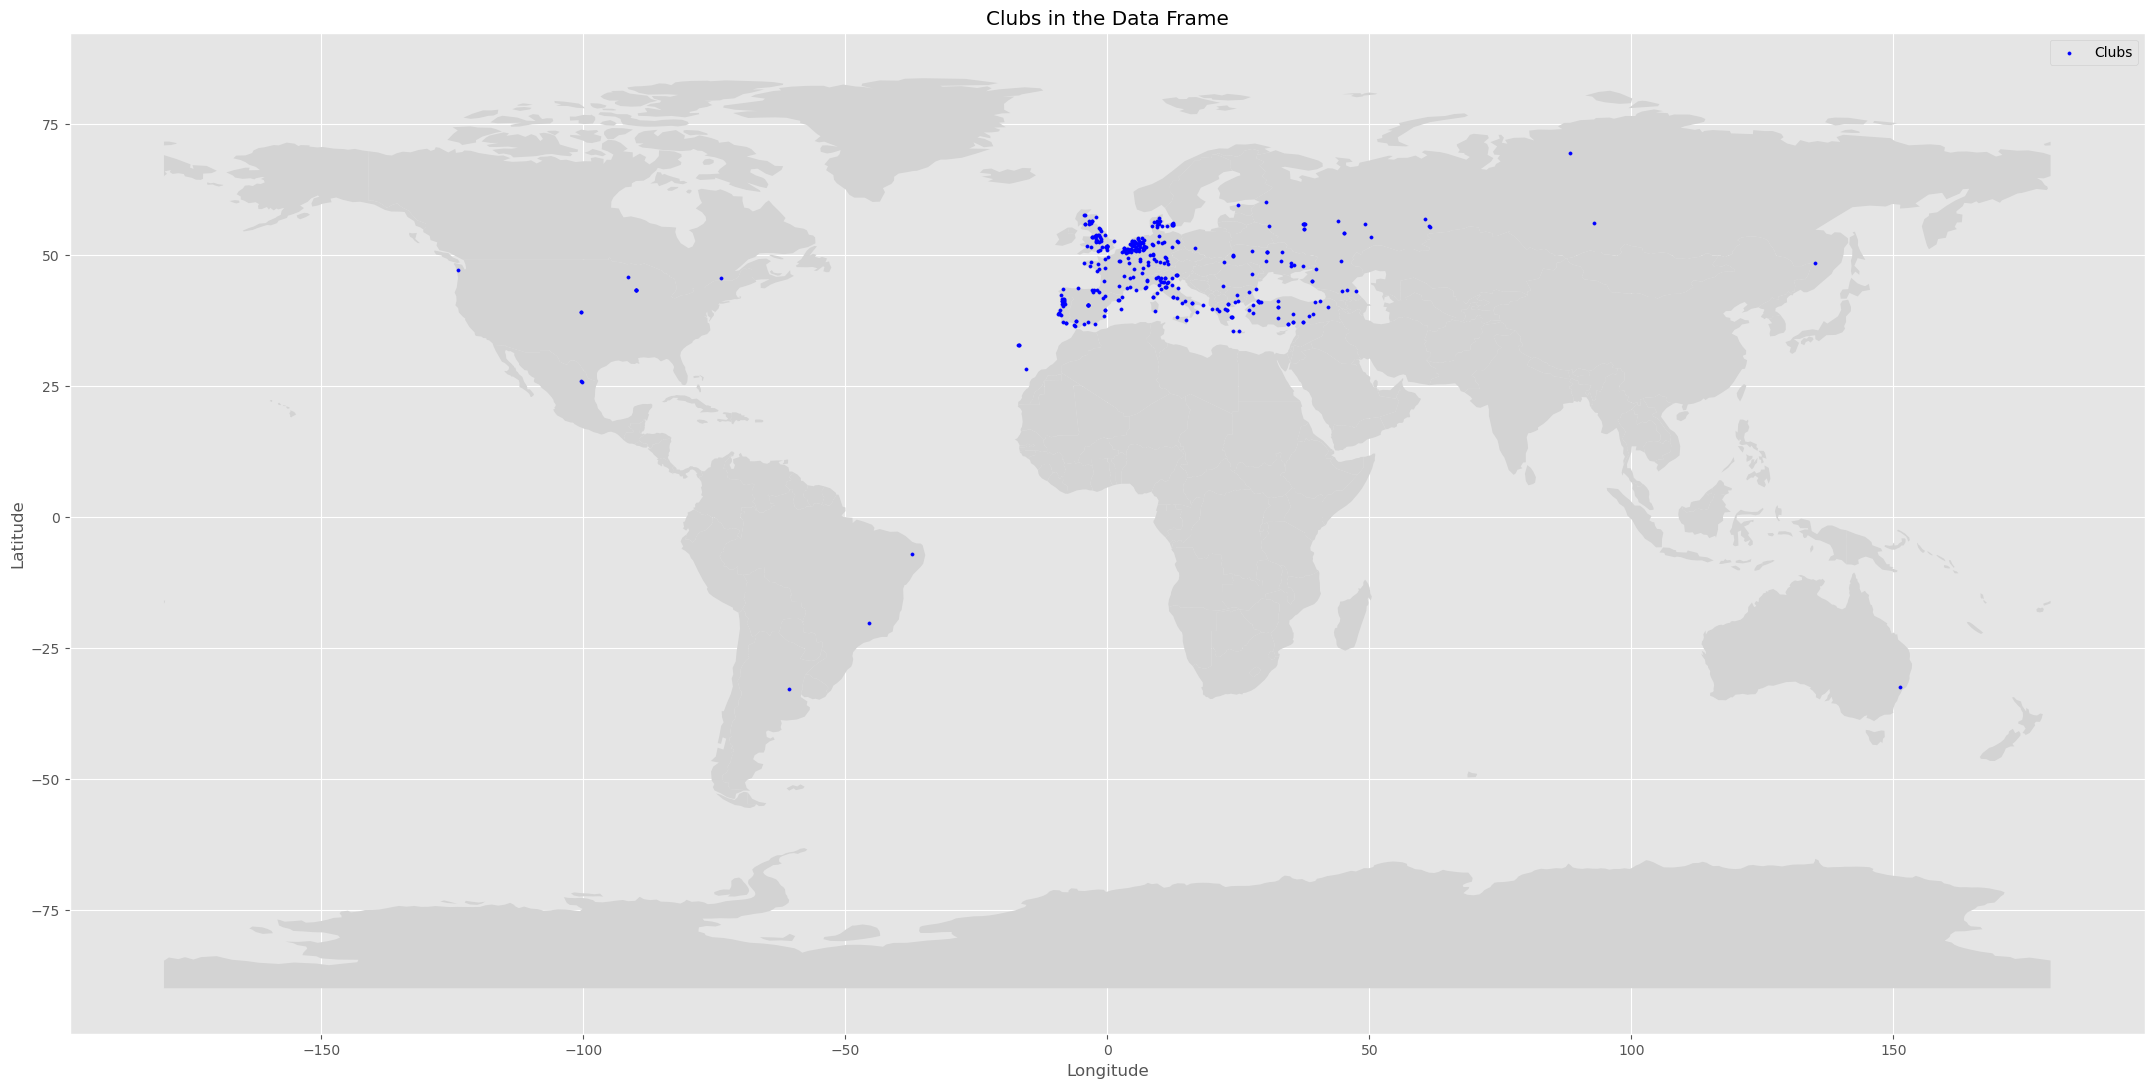

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,net_transfer_record,last_season,latitude,longitude,geometry,club_location
137,976,cf-uniao-madeira,CF União Madeira (-2021),PO1,NaN,0,NaN,0,NaN,0,Centro Desportivo da Madeira,+-0,2015,32.690720,-17.048938,POINT (-17.04894 32.69072),Portugal
145,1301,cs-maritimo,CS Marítimo,PO1,NaN,29,27.2,19,65.5,2,Estádio do Marítimo,+€200k,2022,32.645502,-16.928398,POINT (-16.9284 32.6455),Portugal
359,472,ud-las-palmas,Unión Deportiva Las Palmas S.A.D.,ES1,NaN,26,27.1,8,30.8,3,Estadio de Gran Canaria,€-4.80m,2023,28.100234,-15.456725,POINT (-15.45672 28.10023),Spain
365,982,cd-nacional,CD Nacional,PO1,NaN,27,25.0,12,44.4,2,Estádio da Madeira,+-0,2020,32.670623,-16.883564,POINT (-16.88356 32.67062),Portugal


In [438]:
# Load the world map from the downloaded shapefile
world = gpd.read_file('geopandas_shapefile/ne_110m_admin_0_countries.shp') # World map (world) is loaded using gpd.read_file()

fig, ax = plt.subplots(figsize=(29, 13))
world.plot(ax=ax, color='lightgrey')

# Plot club locations
gdf_club.plot(ax=ax, color='blue', markersize=5, label='Clubs')

plt.title('Clubs in the Data Frame')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Test to verify if the small dots near Morocco are a real location or part of the ocean.
madeira_and_canarias_islands = gdf_club[(gdf_club['longitude'] < -10.0) & (gdf_club['longitude'] > -30.0)] # They are islands near Marocco. 
display(madeira_and_canarias_islands)

### Generate and Visualize graph with all Clubs (Europe View)
Europe map (europe_map) is created as a subset of world containing only European countries.

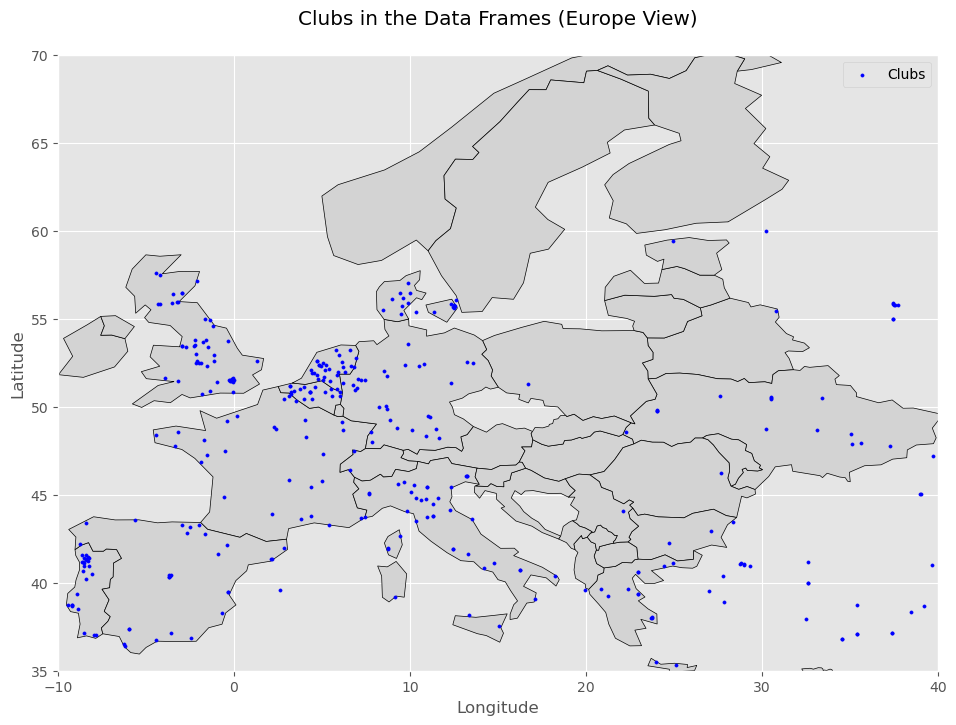

In [439]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Plot the Europe map with player movements
fig, ax = plt.subplots(figsize=(12, 8))
europe_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot player movements as points
gdf_club.plot(ax=ax, color='blue', markersize=5, label='Clubs')

# Adjust plot limits to ensure all points are visible
ax.set_xlim([-10, 40])
ax.set_ylim([35, 70])

plt.title('Clubs in the Data Frames (Europe View)\n')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Generate and Visualize graph with all Player Movements between clubs (Global View)
All player movements are visualized using red lines connecting previous and current club locations

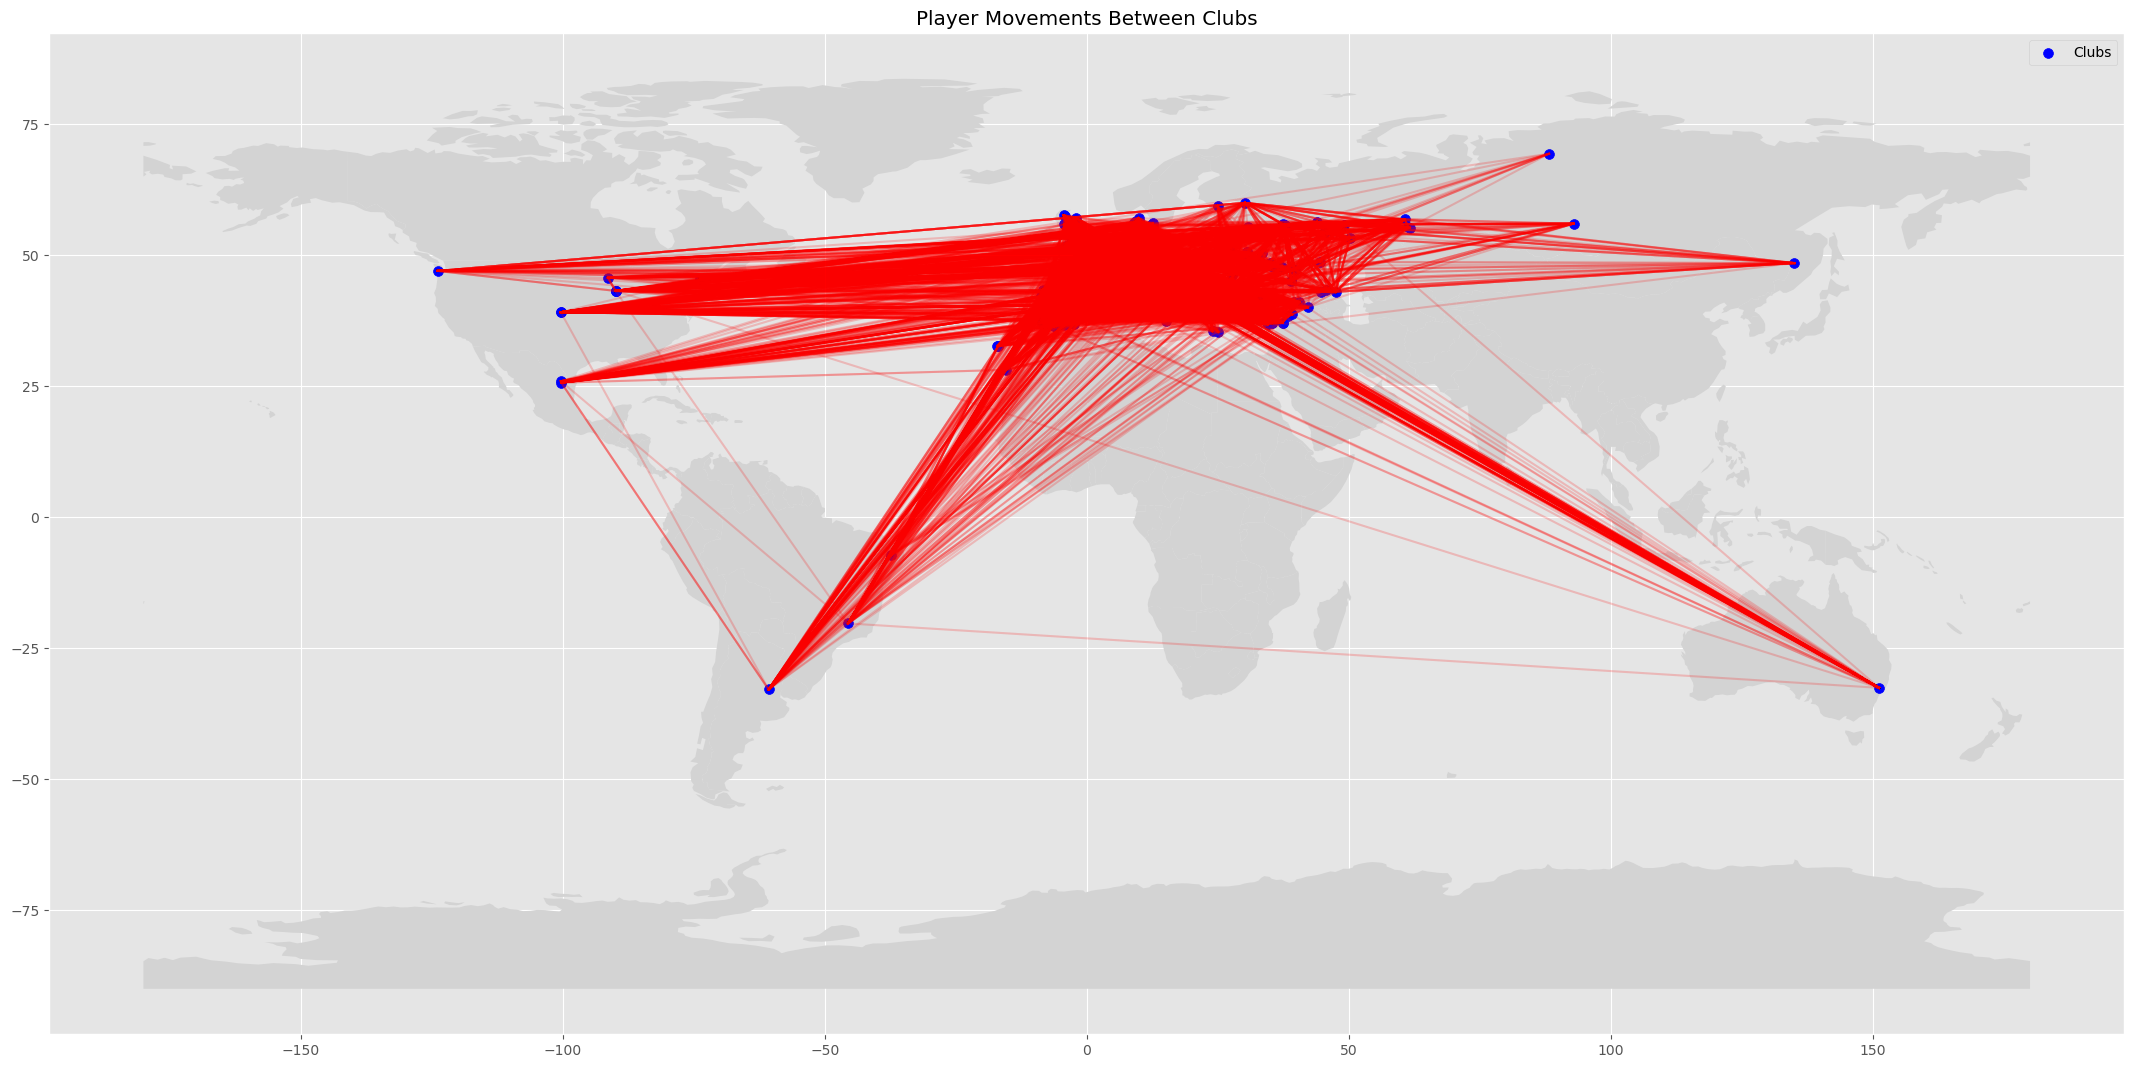

In [440]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Load the world map from the downloaded shapefile
world = gpd.read_file('geopandas_shapefile/ne_110m_admin_0_countries.shp')

fig, ax = plt.subplots(figsize=(29, 13))
world.plot(ax=ax, color='lightgrey')

# Plot club locations
gdf_club.plot(ax=ax, color='blue', markersize=50, label='Clubs')

# Plot player movements as lines
for idx, row in df_player_movements.iterrows():
    plt.plot([row['longitude_prev'], row['longitude_curr']], [row['latitude_prev'], row['latitude_curr']], color='red', alpha=0.2)

plt.title('Player Movements Between Clubs')
plt.legend()
plt.show()

### Get player with the highest movements between clubs

In [441]:
gdf_club = gpd.GeoDataFrame(df_club, geometry=gpd.points_from_xy(df_club.longitude, df_club.latitude))

# Count the number of unique clubs each player has been associated with
player_club_counts = df_app[['player_id', 'player_club_id']].drop_duplicates().groupby('player_id').count()

# Merge with df_players to get player names
player_club_counts = player_club_counts.merge(df_players[['player_id', 'name']], on='player_id')

# Identify the player with the highest number of club movements
player_with_max_movements = player_club_counts.loc[player_club_counts['player_club_id'].idxmax()]

# Get player ID and name
player_id_with_max_movements = player_with_max_movements['player_id']
player_name_with_max_movements = player_with_max_movements['name']

# Filter movements for this player
df_player_movements = df_app[df_app['player_id'] == player_id_with_max_movements][['player_id', 'player_club_id', 'player_current_club_id']].drop_duplicates()

# Merge to get current and previous club locations
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_club_id', right_on='club_id', suffixes=('_prev', '_curr'))
df_player_movements = df_player_movements.merge(df_club[['club_id', 'latitude', 'longitude']], left_on='player_current_club_id', right_on='club_id', suffixes=('_prev', '_curr'))

# Filter out movements with missing coordinates
df_player_movements.dropna(subset=['latitude_prev', 'longitude_prev', 'latitude_curr', 'longitude_curr'], inplace=True)


### Generate and Visualize graph with player with the highest movements between clubs (Global View)
All player movements are visualized using red lines connecting previous and current club locations

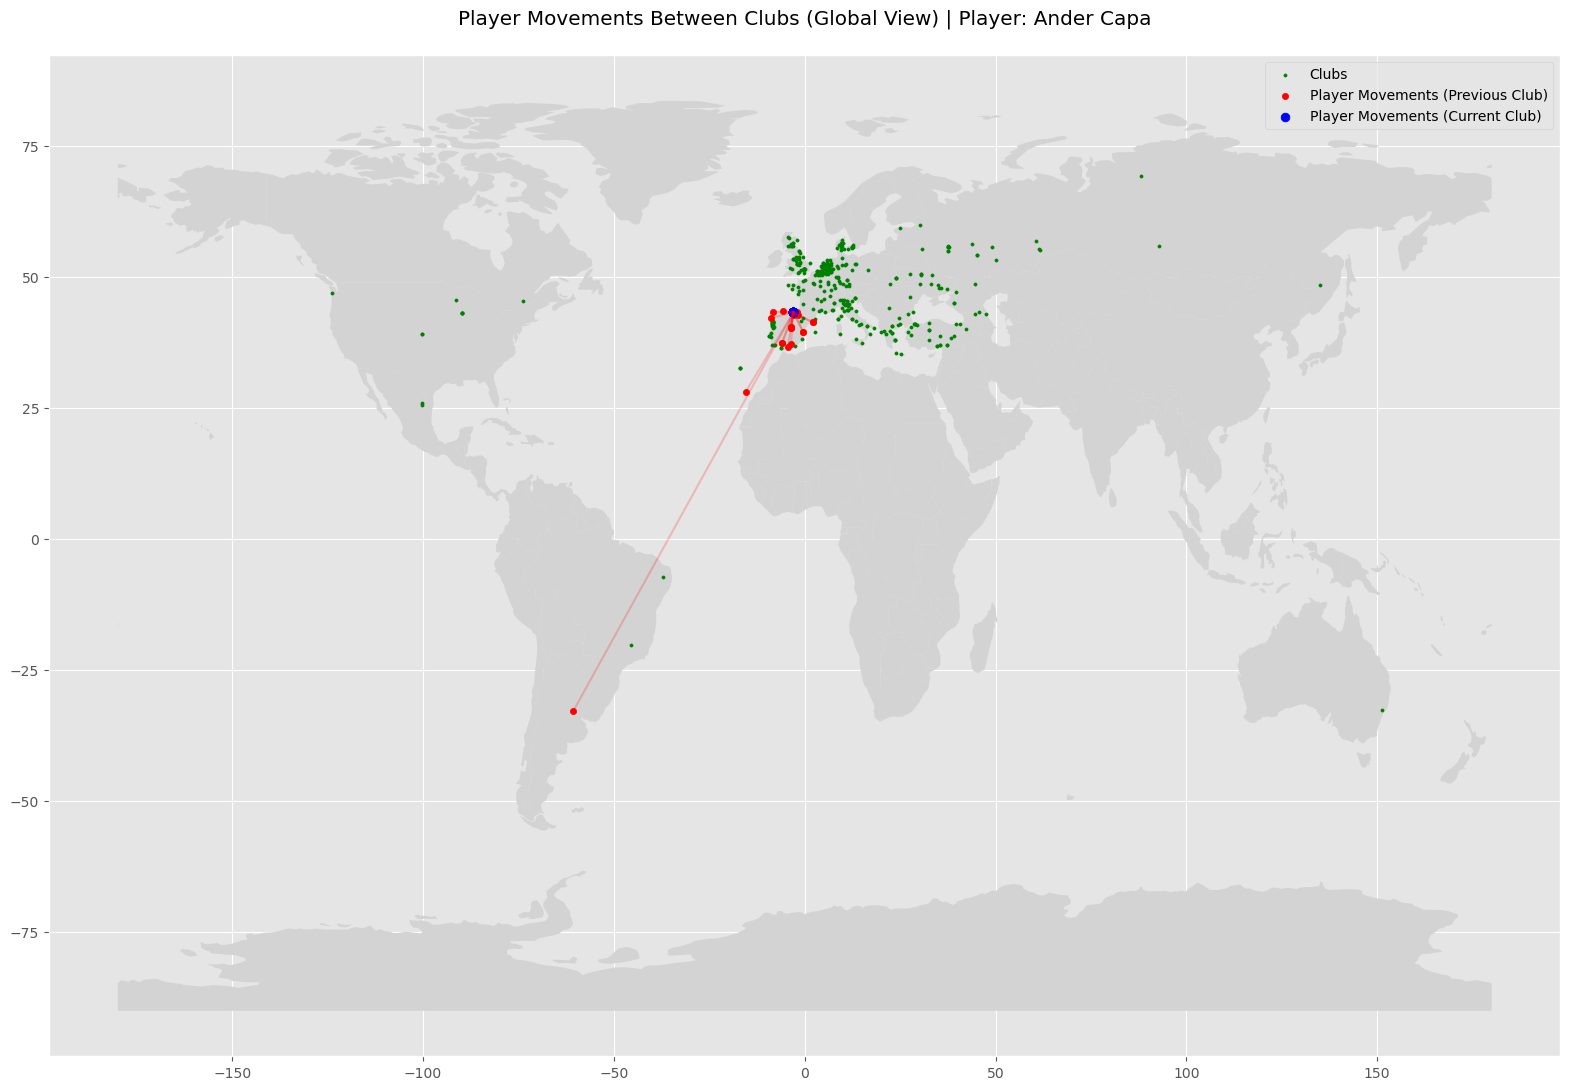

In [450]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Load the world map from the downloaded shapefile
world = gpd.read_file('geopandas_shapefile/ne_110m_admin_0_countries.shp') # World map (world) is loaded using gpd.read_file()

fig, ax = plt.subplots(figsize=(29, 13))
world.plot(ax=ax, color='lightgrey')

# Plot club locations
gdf_club.plot(ax=ax, color='green', markersize=5, label='Clubs')

# Plot player movements as points
gdf_prev.plot(ax=ax, color='red', markersize=20, label='Player Movements (Previous Club)')
gdf_curr.plot(ax=ax, color='blue', markersize=40, label='Player Movements (Current Club)')

# Plot player movements as lines
for idx, row in df_player_movements.iterrows():
    plt.plot([row['longitude_prev'], row['longitude_curr']], [row['latitude_prev'], row['latitude_curr']], color='red', alpha=0.2)

plt.title(f'Player Movements Between Clubs (Global View) | Player: {player_name_with_max_movements}\n')
plt.legend()
plt.show()

### Generate and Visualize player with the highest movements between clubs (Europe View)

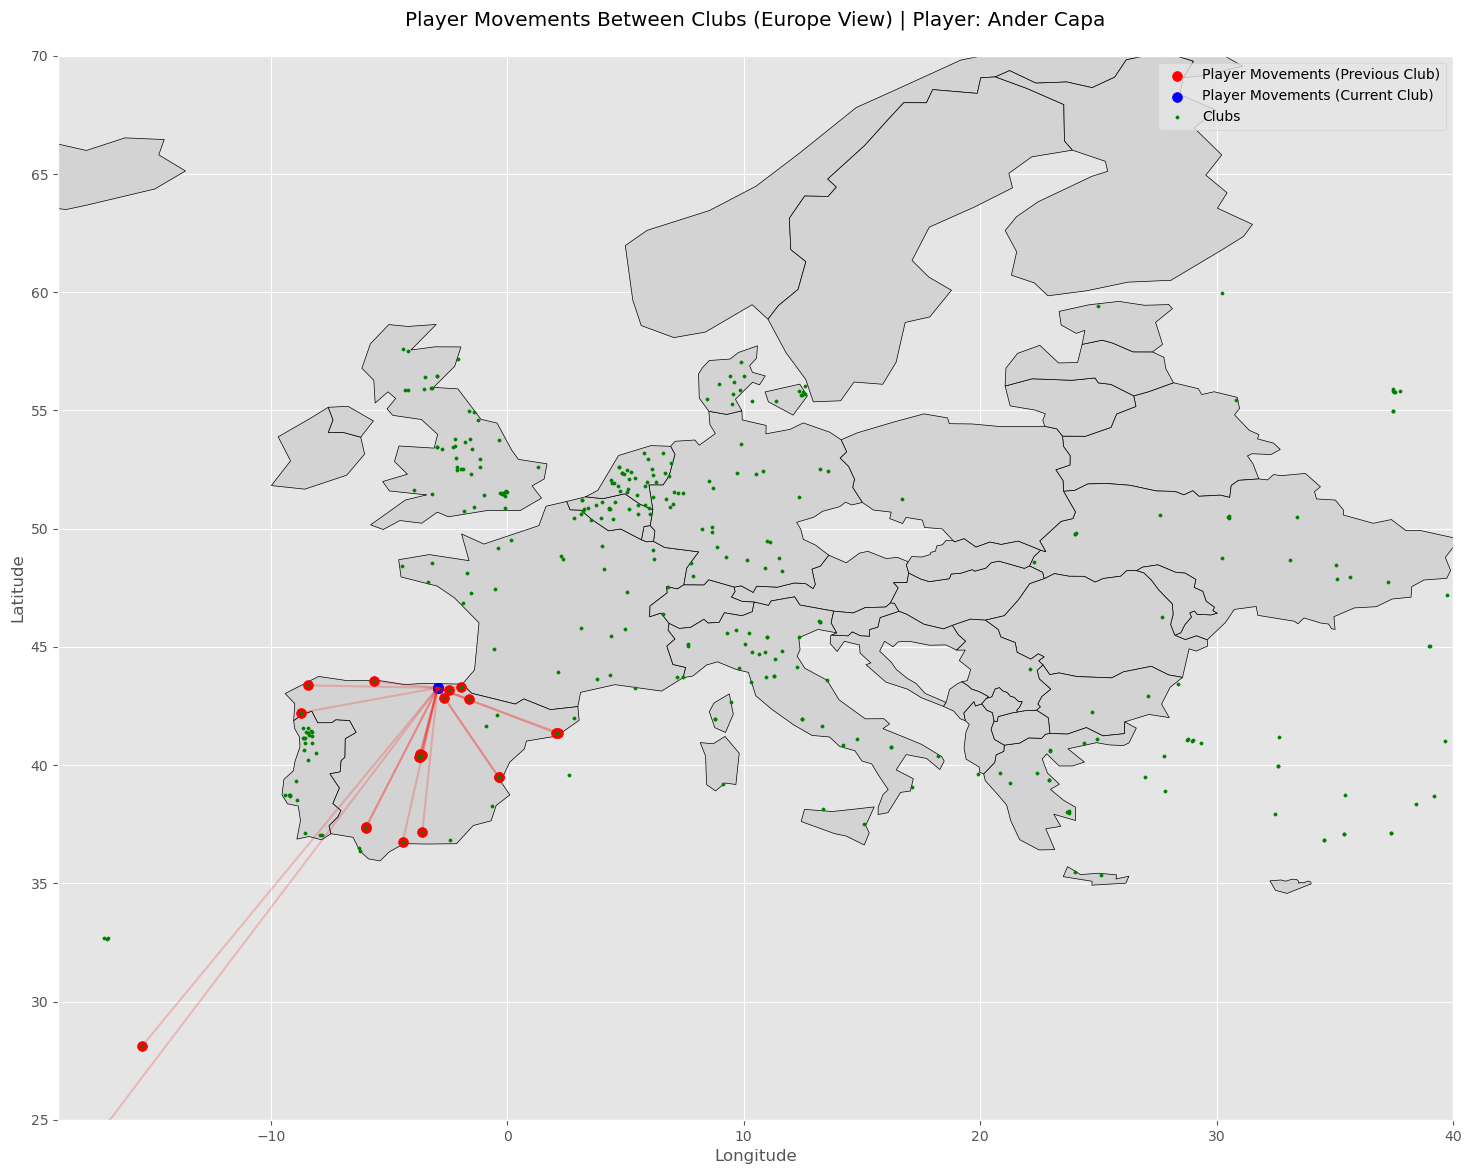

In [449]:
# Create GeoDataFrame for player movements
gdf_movements = gpd.GeoDataFrame(df_player_movements, geometry=gpd.points_from_xy(df_player_movements.longitude_curr, df_player_movements.latitude_curr))

# Plot the Europe map with player movements
fig, ax = plt.subplots(figsize=(18, 18))
europe_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot player movements as points
gdf_prev.plot(ax=ax, color='red', markersize=50, label='Player Movements (Previous Club)')
gdf_curr.plot(ax=ax, color='blue', markersize=50, label='Player Movements (Current Club)')
gdf_club.plot(ax=ax, color='green', markersize=5, label='Clubs')

# Plot player movements as lines
for idx, row in df_player_movements.iterrows():
    plt.plot([row['longitude_prev'], row['longitude_curr']], [row['latitude_prev'], row['latitude_curr']], color='red', alpha=0.2)
    
# Adjust plot limits to ensure all points are visible
ax.set_xlim([-19, 40])  # Example adjustment based on data extent
ax.set_ylim([25, 70])   # Example adjustment based on data extent

plt.title(f'Player Movements Between Clubs (Europe View) | Player: {player_name_with_max_movements}\n')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()